# Comparing two simulations side-by-side

In [ ]:
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

In [2]:
# set the matplotlib font size for the paper plots
plt.rcParams.update({'font.size': 12})

In [3]:
import beorn

21:34:50 - DEBUG - _utils.py - Registered filter: bshuf (/users/rmoll/beorn/.venv/lib/python3.11/site-packages/hdf5plugin/plugins/libh5bshuf.so)
21:34:50 - DEBUG - _utils.py - Registered filter: blosc (/users/rmoll/beorn/.venv/lib/python3.11/site-packages/hdf5plugin/plugins/libh5blosc.so)
21:34:50 - DEBUG - _utils.py - Registered filter: blosc2 (/users/rmoll/beorn/.venv/lib/python3.11/site-packages/hdf5plugin/plugins/libh5blosc2.so)
21:34:50 - DEBUG - _utils.py - Registered filter: bzip2 (/users/rmoll/beorn/.venv/lib/python3.11/site-packages/hdf5plugin/plugins/libh5bzip2.so)
21:34:50 - DEBUG - _utils.py - Registered filter: fcidecomp (/users/rmoll/beorn/.venv/lib/python3.11/site-packages/hdf5plugin/plugins/libh5fcidecomp.so)
21:34:50 - DEBUG - _utils.py - Registered filter: lz4 (/users/rmoll/beorn/.venv/lib/python3.11/site-packages/hdf5plugin/plugins/libh5lz4.so)
21:34:50 - DEBUG - _utils.py - Registered filter: sperr (/users/rmoll/beorn/.venv/lib/python3.11/site-packages/hdf5plugin/pl

In [ ]:
# Painting has been done in a slurm job, so we can load the data from the hdf5 file

CACHE_ROOT = Path(os.getenv("SCRATCH"))
output_handler = beorn.io.Handler(CACHE_ROOT / "output")

21:34:51 - INFO - handler.py - Using persistence directory at /capstor/scratch/cscs/rmoll/output and kwargs None


## The parameters and their radiation profiles

In [5]:
grid_data_base = output_handler.file_root

In [ ]:
multi_z_quantities = [
    beorn.structs.GridDataMultiZ.read(grid_data_base / "GridDataMultiZ_7d39620ad18a493148847bd21fa021bf_param=validation.yaml.h5"),
    beorn.structs.GridDataMultiZ.read(grid_data_base / "GridDataMultiZ_42dc369c8ee22e9f8ba3253769fd5b5c_param=validation_high_res.yaml.h5"),
    beorn.structs.GridDataMultiZ.read(grid_data_base / "GridDataMultiZ_bbb7445fbfcb68fb603c18bf076312f0_param=validation_thesan_1.yaml.h5"),
]

labels = [
    '$128^3$ (fiducial)',
    '$256^3$',
    '$128^3$ (Thesan-Dark-1)',
]

In [7]:
colors = plt.cm.Set1(
    np.linspace(0, 1, len(labels))
)
colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))

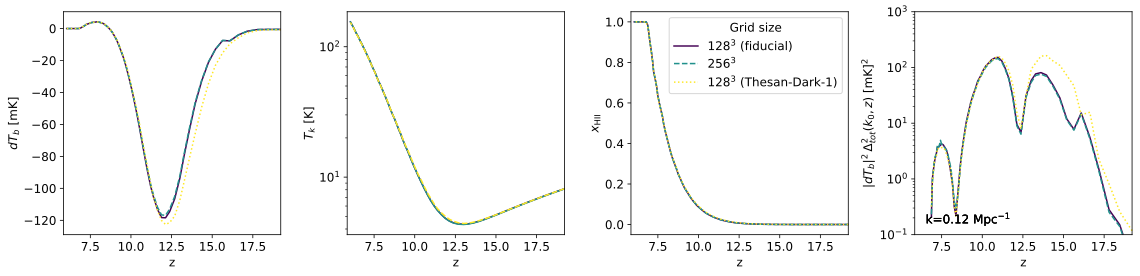

In [ ]:
# For the report the diffs of the validation are not relevant, so we simplify:
# only plot the signals and share for each rerun

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
fig.set_layout_engine('tight')
plt.rcParams.update({'font.size': 12})
fig.set_linewidth(3)
axs = axs.flatten()

for grid, label, color in zip(multi_z_quantities, labels, colors):
    if grid == multi_z_quantities[1]:
        z = grid.z[:]

        dtb_signal = np.mean(grid.Grid_dTb[:], axis=(1,2,3))
        axs[0].plot(z, dtb_signal, label=label, color=color)

        temp_signal = np.mean(grid.Grid_Temp[:], axis=(1,2,3))
        axs[1].semilogy(z, temp_signal, label=label, color=color)

        xhii_signal = np.mean(grid.Grid_xHII[:], axis=(1,2,3))
        axs[2].plot(z, xhii_signal, label=label, color=color)
        beorn.plotting.draw_dTb_power_spectrum_of_z(axs[3], grid, grid.parameters, label=label, color=color)


    else:
        beorn.plotting.draw_dTb_signal(axs[0], grid, label=label, color=color)
        beorn.plotting.draw_Temp_signal(axs[1], grid, label=label, color=color)
        beorn.plotting.draw_xHII_signal(axs[2], grid, label=label, color=color)
        beorn.plotting.draw_dTb_power_spectrum_of_z(axs[3], grid, grid.parameters, label=label, color=color)

for ax in axs:
    ax.lines[-2].set_linestyle('--')
    ax.lines[-1].set_linestyle('dotted')


axs[2].legend(title="Grid size")
fig.show()

In [ ]:
# NB: a full comparison plot that includes a separate plot of the relative differences can be obtained through:

fig = plt.figure(figsize=(14, 6))
fig.set_linewidth(3)
fig.set_layout_engine('constrained')

baseline = multi_z_quantities[0]
for grid, label, color in zip(multi_z_quantities, labels, colors):
    beorn.plotting.full_diff_plot(fig, grid, baseline, label, color)

# add a legend, in this case the 3rd ax is most suitable
fig.axes[2].legend(loc='best')
fig.show()

#### Lightcones and maps

In [ ]:
lightcones = []

for grid in multi_z_quantities:
    lightcone = beorn.structs.Lightcone.build(
        grid.parameters,
        grid,
        quantity="Grid_dTb",
    )
    lightcones.append(lightcone)

Making lightcone between 0.049459 < z < 0.141782


100%|██████████| 510/510 [00:00<00:00, 548.60it/s]


...done
Making lightcone between 0.049459 < z < 0.141962


100%|██████████| 1021/1021 [00:05<00:00, 175.94it/s]


...done
Making lightcone between 0.049459 < z < 0.141782


100%|██████████| 510/510 [00:00<00:00, 552.71it/s]

...done


In [ ]:
fig, axs = plt.subplots(len(multi_z_quantities), 1, figsize=(15, 3 * len(multi_z_quantities)), constrained_layout=True)

if len(multi_z_quantities) == 1:
    axs = [axs]

for ax, lightcone, desc in zip(axs, lightcones, labels):
    beorn.plotting.plot_lightcone(lightcone, ax, desc)
    ax.axes.get_xaxis().set_visible(False)

# re-add the bottom-most x-axis
axs[-1].axes.get_xaxis().set_visible(True)

plt.subplots_adjust(hspace=0.4)  # Increase vertical space between axes
plt.show()

15:54:36 - DEBUG - lightcone.py - Lightcone dynamic range is -2.09e+02 to 3.14e+01
15:54:36 - DEBUG - lightcone.py - Plotting slice 64 with xi.shape=(128, 510) x yi.shape=(128, 510) x zj.shape=(127, 509)
15:54:36 - DEBUG - lightcone.py - Lightcone dynamic range is -2.40e+02 to 1.08e+02
15:54:36 - DEBUG - lightcone.py - Plotting slice 128 with xi.shape=(256, 1021) x yi.shape=(256, 1021) x zj.shape=(255, 1020)
15:54:36 - DEBUG - lightcone.py - Lightcone dynamic range is -1.97e+02 to 3.09e+01
15:54:36 - DEBUG - lightcone.py - Plotting slice 64 with xi.shape=(128, 510) x yi.shape=(128, 510) x zj.shape=(127, 509)


In [ ]:
ionization_fractions = [0.1, 0.5, 0.8, 0.9, 1.0]

fig, axs = plt.subplots(1, len(ionization_fractions), figsize=(20, 4), constrained_layout=True)

for grid, desc, color in zip(multi_z_quantities, labels, colors):
    pk, k = grid.power_spectrum(grid.Grid_dTb, grid.parameters)
    for i, ax in enumerate(axs):
        redshift_index = grid.redshift_of_reionization(ionization_fractions[i])
        dtb = np.nanmean(grid.Grid_dTb[redshift_index, ...])
        redshift = grid.z[redshift_index]
        ax.loglog(k, dtb**2 * k**3 * pk[redshift_index, ...], label=f"{desc} (z={redshift:.2f})", color=color)
        ax.set_title(f"Ionization fraction {ionization_fractions[i]}")

for ax in axs:
    ax.set_xlabel("k [Mpc$^{-1}$]")
    ax.set_ylabel("$\\Delta^2 \\cdot \\overline{d_{Tb}}^2$ [mK$^2$]")
    ax.legend(fontsize='small')

plt.show()